In [184]:
!nvidia-smi

Thu Feb  4 16:51:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    40W / 250W |  16213MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [3]:
!pip install git+https://github.com/ShivamShrirao/dnn_from_scratch.git

  Cloning https://github.com/ShivamShrirao/dnn_from_scratch.git to /tmp/pip-req-build-_owdext0
  Running command git clone -q https://github.com/ShivamShrirao/dnn_from_scratch.git /tmp/pip-req-build-_owdext0
  Created wheel for dnn-from-scratch: filename=dnn_from_scratch-0.1.dev1-cp36-none-any.whl size=40795 sha256=3b495ad04e73d0043a1fbc6eca5ef2b55ee7dee8df959f9719ac3c23fd8d84b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjrd1zkx/wheels/33/77/6c/1140f6295368e7045f3b49fdda98e7f07b2513b8b55093ca7b
Successfully built dnn-from-scratch


In [4]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import Conv2D,MaxPool,Flatten,Dense,Dropout,Conv2Dtranspose,Upsampling,Reshape,BatchNormalization,Activation
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np
import cupy as cp

In [5]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:15<00:00, 85.4MB/s]
100% 1.14G/1.14G [00:15<00:00, 80.5MB/s]


In [7]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [8]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [36]:
batch_size = 64

img_height = 150
img_width = 150

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [192]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [139]:
a,b = train.next()

In [140]:
a.shape, b.shape

((64, 150, 150, 3), (64,))

In [141]:
len(train_gen)

66

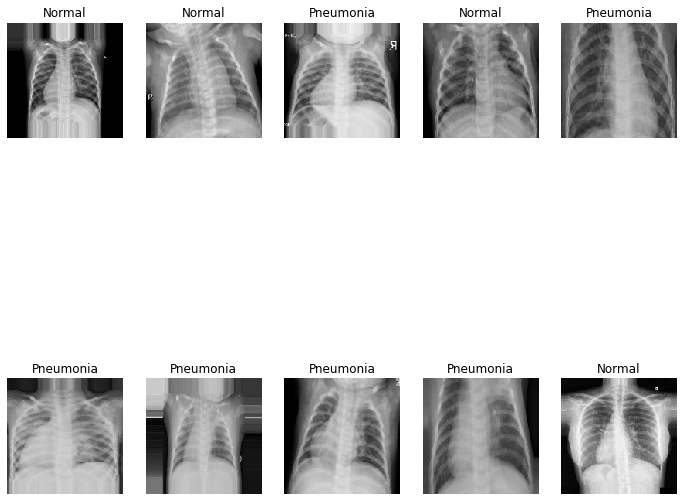

In [13]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [ ]:
# VERIFY when biases are zero

In [190]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding=None, input_shape=(img_width,img_height,3)))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), padding=None, stride=(2,2)))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

# model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), padding=None))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), padding=None, stride=(2,2)))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

# model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3), padding=None))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), padding=None, stride=(2,2)))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

# model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3,3), padding=None))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), padding=None, stride=(2,2)))
model.add(Activation(functions.elu))
model.add(BatchNormalization())

model.add(MaxPool())

model.add(Flatten())

model.add(Dense(128))

model.add(Activation(functions.elu))

model.add(BatchNormalization())

model.add(Dropout(0.75))

model.add(Dense(1, activation=functions.sigmoid))

model.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error, learning_rate=0.001)

In [191]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 150, 150, 3)        echo             0
__________________________________________________________________________________________
0 Conv2D(Conv2D)          (None, 150, 150, 32)       echo             896
__________________________________________________________________________________________
1 Activation(Activation)  (None, 150, 150, 32)       elu              0
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 150, 150, 32)       echo             128
__________________________________________________________________________________________
3 Conv2D(Conv2D)          (None, 75, 75, 32)         echo             9248
__________________________________________________________________________________________
4 Activat

In [27]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [108]:
from tqdm.notebook import tqdm
from nnet_gpu.stream_handler import stream_maps
eval_stream = stream_maps.get_next_stream()

In [179]:
def model_loop(diter, eval=False):
    acc = 0
    loss = 0
    pbar = tqdm(range(len(diter)))
    ptext = "Validation " if eval else ""
    for idx in pbar:
        inp, y_inp = diter.next()
        inp = cp.asarray(inp)
        y_inp = cp.asarray(y_inp[:, None])
        if eval:
            outputs = model.predict(inp)
        else:
            outputs = model.train_on_batch(inp, y_inp)
        model.logit_event = cp.cuda.get_current_stream().record()
        with eval_stream:
            eval_stream.wait_event(model.logit_event)
            pred = outputs > 0.5
            acc += (pred == y_inp.astype(cp.bool)).mean().get(eval_stream)
            loss += model.loss(outputs=outputs, labels=y_inp).mean().get(eval_stream)
            pbar.set_postfix({ptext+'Accuracy': f"{acc/(idx+1):.4f}", ptext+'Loss': f"{loss/(idx+1):.4f}",
                                'Learning Rate': f"{model.learning_rate}"})

In [181]:
model.learning_rate = 1e-3

In [187]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model_loop(train)
    model_loop(valid, eval=True)
    if model.learning_rate < 1e-4/2:
        model.learning_rate = 1e-4
    else:
        model.learning_rate/= 2

Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


In [193]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model_loop(train)
    model_loop(valid, eval=True)
    if model.learning_rate < 1e-4/2:
        model.learning_rate = 1e-4
    else:
        model.learning_rate/= 2

Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


## Evaluate

In [194]:
model_loop(test, eval=True)

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [189]:
model_loop(test, eval=True)

In [ ]:
y_bar = np.round(model.predict(test)).reshape(-1)
y_act = test.labels

In [ ]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9230769230769231
ROC-AUC score:  0.9290865384615384
F1 score:  0.9404466501240696
Log Loss:  2.6568430489221884
